In [ ]:
# Dinamic Time Warping
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
from tslearn.metrics import cdist_dtw

# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Sequential # for assembling a Neural Network model
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, ReLU, LeakyReLU, Dropout # adding layers to the Neural Network model
from tensorflow.keras.utils import plot_model # for plotting model diagram
from tensorflow.keras.optimizers import Adam # for model optimization


# Data manipulation
import pandas as pd
print('pandas: %s' % pd.__version__) # print version

import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version
import sklearn
print('sklearn: %s' % sklearn.__version__) # print version
from sklearn.preprocessing import MinMaxScaler # for scaling inputs used in the generator and discriminator


# Visualization
import cv2 # for ingesting images
print('OpenCV: %s' % cv2.__version__) # print version
import matplotlib
import matplotlib.pyplot as plt # or data visualizationa
print('matplotlib: %s' % matplotlib.__version__) # print version
import graphviz # for showing model diagram
print('graphviz: %s' % graphviz.__version__) # print version


# Other utilities
import sys
import os

# Assign main directory to a variable
# main_dir=os.path.dirname(sys.path[0])
main_dir = './content'
print(main_dir)



# Deep Convolutional Generative Adversarial Network (DCGAN)

## Load data

In [ ]:
data_path = 'CWRU_datasets/CWRU_preprocess_data/unbalanced_dataset/unbalanced_npy_by_labels'

x_train = np.load(f'{data_path}/normaliced_data/x_train_norm_label1_20samples.npy')

# 2D format
n_img = 20 # time series
data = x_train.reshape(n_img,40,40,1)

# Show data shape
print("Shape of data_lowres: ", data.shape)

In [ ]:
display10 = data.astype(np.float64)

# Display 10 real images
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(10,5), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(display10[n])
        n=n+1
plt.show()

# Setup GAN

### Generator model

In [ ]:
def generator(latent_dim):
    model = Sequential(name="Generator") # Model

    # Hidden Layer 1: Start with 5 x 5 image
    n_nodes = 5 * 5 * 128 # number of nodes in the first hidden layer
    model.add(Dense(n_nodes, input_dim=latent_dim, name='Generator-Hidden-Layer-1'))
    model.add(Reshape((5, 5, 128), name='Generator-Hidden-Layer-Reshape-1'))

    # Hidden Layer 2: Upsample to 10 x 10
    model.add(Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-2'))
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-2'))

    # Hidden Layer 3: Upsample to 20 x 20
    model.add(Conv2DTranspose(filters=256, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-3'))
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-3'))

    # Hidden Layer 4: Upsample to 40 x 40
    model.add(Conv2DTranspose(filters=512, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-4'))
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-4'))

    # Output Layer (Note, we use 3 filters if we have 3 channels for a color image. Grayscale would have only 1 channel)
    model.add(Conv2D(filters=1, kernel_size=(5,5), activation='sigmoid', padding='same', name='Generator-Output-Layer'))
    return model

# Instantiate
latent_dim=100 # Our latent space has 100 dimensions. We can change it to any number
gen_model = generator(latent_dim)

# Show model summary and plot model diagram
gen_model.summary()
plot_model(gen_model, show_shapes=True, show_layer_names=True, dpi=60) #, to_file='generator_structure.png')

### Discriminator model

In [ ]:
def discriminator(in_shape=(40,40,1)):
    model = Sequential(name="Discriminator") # Model

    # Hidden Layer 1
    model.add(Conv2D(filters=64, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-1'))
    model.add(LeakyReLU(negative_slope=0.2, name='Discriminator-Hidden-Layer-Activation-1'))

    # Hidden Layer 2
    model.add(Conv2D(filters=128, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-2'))
    model.add(LeakyReLU(negative_slope=0.2, name='Discriminator-Hidden-Layer-Activation-2'))

    # Hidden Layer 3
    model.add(Conv2D(filters=128, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-3'))
    model.add(LeakyReLU(negative_slope=0.2, name='Discriminator-Hidden-Layer-Activation-3'))

    # Flatten and Output Layers
    model.add(Flatten(name='Discriminator-Flatten-Layer')) # Flatten the shape
    model.add(Dropout(0.3, name='Discriminator-Flatten-Layer-Dropout')) # Randomly drop some connections for better generalization
    model.add(Dense(1, activation='sigmoid', name='Discriminator-Output-Layer')) # Output Layer

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    return model

# Instantiate
dis_model = discriminator()

# Show model summary and plot model diagram
dis_model.summary()
plot_model(dis_model, show_shapes=True, show_layer_names=True, dpi=60) #, to_file='discriminator_structure.png')

### Generator and Discriminator models into trainable GAN



In [ ]:
def def_gan(generator, discriminator):

    # We don't want to train the weights of discriminator at this stage. Hence, make it not trainable
    discriminator.trainable = False

    # Combine
    model = Sequential(name="DCGAN") # GAN Model
    model.add(generator) # Add Generator
    model.add(discriminator) # Add Disriminator

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model

# Instantiate
gan_model = def_gan(gen_model, dis_model)

# Show model summary and plot model diagram
gan_model.summary()
plot_model(gan_model, show_shapes=True, show_layer_names=True, dpi=60) #, to_file='dcgan_structure.png')

### Function to sample real images

In [ ]:
def real_samples(n, dataset):

    # Samples of real data
    X = dataset[np.random.choice(dataset.shape[0], n, replace=True), :]

    # Class labels
    y = np.ones((n, 1))

    return X, y

### Generate points in the latent space, which we will use as inputs for the generator

In [ ]:
def latent_vector(latent_dim, n):

    # Generate points in the latent space
    latent_input = np.random.randn(latent_dim * n)

    # Reshape into a batch of inputs for the network
    latent_input = latent_input.reshape(n, latent_dim)
    return latent_input

### Use the generator to generate n artificial examples together with class labels

In [ ]:
def fake_samples(generator, latent_dim, n):

    # Generate points in latent space
    latent_output = latent_vector(latent_dim, n)

    # Predict outputs (i.e., generate fake samples)
    X = generator.predict(latent_output)

    # Create class labels
    y = np.zeros((n, 1))
    return X, y

# Functions for model performance evaluation and training

### Dinamyc Time Warping

Dynamic time warping  is a way to compare two, usually temporal, sequences that do not perfectly sync up.

In [ ]:
def dtw_mean(x_train, generated_ts, referenceDTW =None):

  # Generated times series DTW againts Original time series
  #########################################################
  means_array = []
  for ts in generated_ts:
    dtw_ts = cdist_dtw(ts,x_train)
    dtw_ts_mean = np.mean(dtw_ts)
    means_array.append(dtw_ts_mean)
  
  dtw_mean = np.mean(means_array)
  
  if referenceDTW != None:
    print('\n')
    print('*** Reference DTW vs Actual DTW***')
    print(f'Reference DTW mean: {referenceDTW}')
    print(f'Actual DTW mean: {dtw_mean}')
  
  return dtw_mean

In [ ]:
# Reference DTW
referenceDTW = dtw_mean(x_train, x_train)

### Discriminator model accuracy and plot real vs. generated time series comparison

In [ ]:
loss_discriminador_array = []
loss_generador_array = []
fake_array = []

In [ ]:
def performance_summary(generator, discriminator, dataset, latent_dim, n=n_img):

    # Get samples of the real data
    x_real, y_real = real_samples(n, dataset)
    # Evaluate the descriminator on real data
    _, real_accuracy = discriminator.evaluate(x_real, y_real, verbose=0)

    # Get fake (generated) samples
    x_fake, y_fake = fake_samples(generator, latent_dim, n)
    # Evaluate the descriminator on fake (generated) data
    _, fake_accuracy = discriminator.evaluate(x_fake, y_fake, verbose=0)

    # summarize discriminator performance
    print('\n')
    print("*** Evaluation ***")
    print("Discriminator Accuracy on REAL images: ", real_accuracy)
    print("Discriminator Accuracy on FAKE (generated) images: ", fake_accuracy)

    # DTW verification
    ##################
    
    # Reshape de las imagenes
    x_fake_reshape = x_fake.reshape(n_img,1600)

    # matriz de distancias
    dtw_mean_value = dtw_mean(x_train, x_fake_reshape, referenceDTW)

    # Plot Generate examples
    ########################
    fig, axs = plt.subplots(1,4, sharey=False, tight_layout=True, figsize=(8,3), facecolor='white')
    k=0
    plt.suptitle('Generated examples')
    for i in range(4):
            axs[i].matshow(x_fake[k])
            k=k+1
    plt.show()

# Train

### Function to train our DCGAN model (generator and discriminator)

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch, n_eval):

    # Our batch to train the discriminator will consist of half real images and half fake (generated) images
    half_batch = int(n_batch / 2)

    # Manually enumare epochs
    for i in range(n_epochs):

    # Discriminator training
        # Prep real samples
        x_real, y_real = real_samples(half_batch, dataset)
        # Prep fake (generated) samples
        x_fake, y_fake = fake_samples(g_model, latent_dim, half_batch)

        # Train the discriminator using real and fake samples
        X, y = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
        discriminator_loss, _ = d_model.train_on_batch(X, y)

    # Generator training
        # Get values from the latent space to be used as inputs for the generator
        x_gan = latent_vector(latent_dim, n_batch)
        # While we are generating fake samples,
        # we want GAN generator model to create examples that resemble the real ones,
        # hence we want to pass labels corresponding to real samples, i.e. y=1, not 0.
        y_gan = np.ones((n_batch, 1))

        # Train the generator via a composite GAN model
        generator_loss = gan_model.train_on_batch(x_gan, y_gan)

        # Evaluate the model at every n_eval epochs
        if (i) % n_eval == 0:
            print('\n')
            print("Epoch number: ", i)
            print("*** Training ***")
            print("Discriminator Loss: ", discriminator_loss)
            loss_discriminador_array.append(discriminator_loss)

            print("Generator Loss: ", generator_loss[0])
            loss_generador_array.append(generator_loss[0])

            performance_summary(g_model, d_model, dataset, latent_dim)

            # # Guardar modelos
            # print('Guardando modelos ...')
            # gen_model.save(f'{save_path}/{label}/{label}_Generator_{i}epoch.h5')
            # dis_model.save(f'{save_path}/{label}/{label}_Discriminator_{i}epoch.h5')
            # gan_model.save(f'{save_path}/{label}/{label}_GAN_{i}epoch.h5')

### Train the model and plot the results



*** Reference DTW vs Actual DTW***
Reference DTW mean: 3.0580396319734904
Actual DTW mean: 6.803646382310245


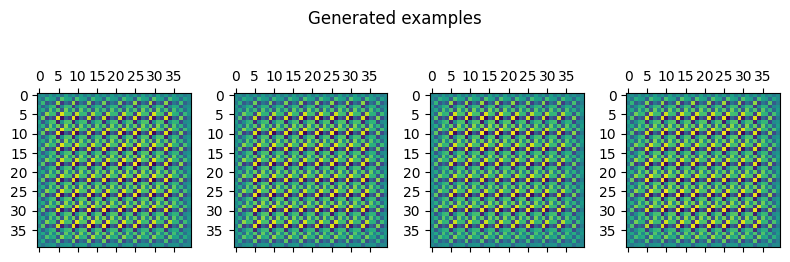

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Epoch number:  20
*** Training ***
Discriminator Loss:  0.7187821
Generator Loss:  0.7187821
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8500000238418579
Discriminator Accuracy on FAKE (generated) images:  0.0


*** Reference DTW vs Actual DTW***
Reference DTW mean: 3.0580396319734904
Actual DTW mean: 15.163051631159433


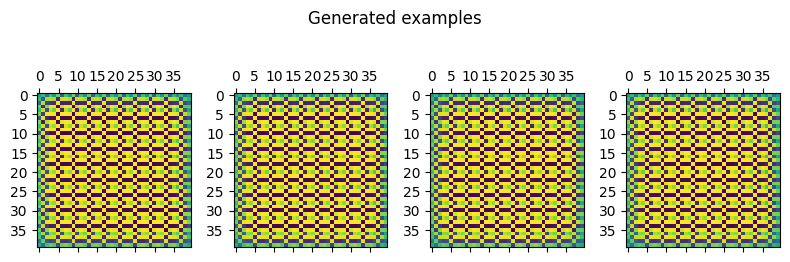

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


In [ ]:
# Train DCGAN model
# 1k epochs
train(gen_model, dis_model, gan_model, data, latent_dim, n_epochs=1001, n_batch=32, n_eval=100)

### References

Dobilas, S. (2022, octubre 15). Deep Convolutional GAN — How to Use a DCGAN to Generate Images in Python.   
https://towardsdatascience.com/deep-convolutional-gan-how-to-use-a-dcgan-to-generate-images-in-python-b08afd4d124e